In [1]:
import yaml
import sep
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import random
from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.table import Table, QTable, Column
from astropy.stats import SigmaClip

from photutils.segmentation import deblend_sources, detect_sources
from photutils.aperture import CircularAperture, aperture_photometry, EllipticalAperture
from photutils import SegmentationImage, segmentation, CircularAperture, aperture_photometry,\
Background2D, SExtractorBackground, MADStdBackgroundRMS
from photutils.datasets import make_gaussian_sources_image

In [2]:
def midbins(bins):
        """define a function to compute the mid-points of the bins from a histogram"""
        size = len(bins)-1
        x_midbins = np.empty(size,dtype='float64')
        for x in range(size):
            x_midbins[x] = np.mean([bins[x],bins[(x+1)]])
        return x_midbins
    
def fit_Gaussian(x,a,mean,sigma):
        """define a function to fit a gaussian to a histogram"""
        return (a * np.exp(-1* ( (x-mean)**2 / (2 * sigma**2) ) ) )
    
def error_power_law_scaling(aper_diameter,alpha,beta):
        """
        define a function to describe the standard deviation of the empty apertures
        distribution as a function of aperture size (entered as DIAMETER in ARCSEC)
        Parameters
        ----------
        aper_diameter: float
            aperture diameter in arcsec
        alpha, beta: float
            normalization constant and slope of power law describing growth
            in empty aperture errors
        """
        radius = aper_diameter / 2.
        N = np.sqrt(np.pi*(radius**2))
        return alpha * N**beta
    
def get_file(filt):
    file = 'files/tadpole_macs0417clu-' + filt + '_40mas_v1p0_bcgs_out_conv_f444w.fits'
    
    data = fits.getdata(file)
    data = data.byteswap().newbyteorder()
    return data

lam_centers = np.array([ 4336.69336693,  5965.0796508 ,  7983.0798308 ,  9052.02052021,
       11629.46629466, 11569.52569526, 15056.07056071, 15016.1101611 ,
       19941.22941229, 19851.31851319, 27663.57663577, 35865.44865449,
       40840.51840518, 44017.3701737 ])
len(lam_centers)

14

In [3]:
# Filters
filters = ['F435W',
 'F606W',
 'F814W',
 'F090W',
 'F115W',
 'F115WN',
 'F150W',
 'F150WN',
 'F200W',
 'F200WN',
 'F277W',
 'F356W',
 'F410M',
 'F444W']
filt_id = [i.lower() for i in filters]
print(len(filt_id))

14


In [4]:
# Loading the data
data = 0
for i in filt_id:
    data += get_file(i)
    
shape = np.shape(data)

In [5]:
# Creating a test source
gaus_table = QTable()
gaus_table['amplitude'] = [200]
gaus_table['x_mean'] = [20]
gaus_table['y_mean'] = [20]
gaus_table['x_stddev'] = [1]
gaus_table['y_stddev'] = [1]

source = make_gaussian_sources_image(shape, gaus_table)
np.sum(source)

1256.6370748833813

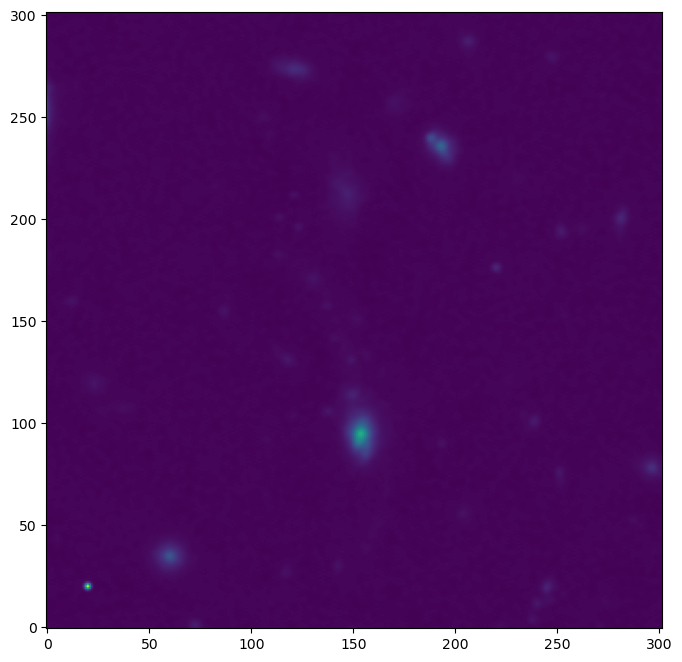

In [6]:
plt.figure(figsize = (12, 8))
plt.imshow(data + source, cmap = 'viridis', origin = 'lower')
plt.show()

  0%|          | 0/33 [00:00<?, ?it/s]

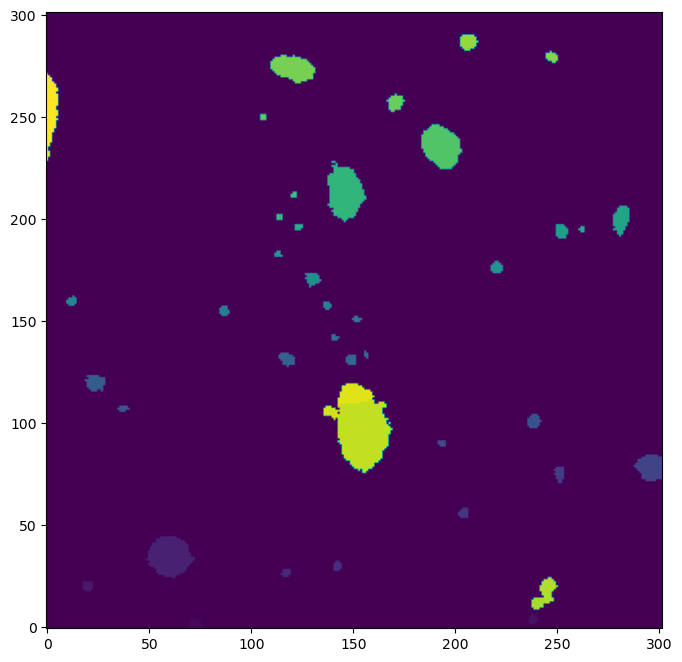

In [7]:
# Detecting the sources
data_bkg = data + source
seg_map = detect_sources(data_bkg, 3.5, npixels=5)
seg_deblend = deblend_sources(data_bkg, seg_map, npixels=5, 
                               nlevels=32, contrast=0.0001)

plt.figure(figsize = (12, 8))
plt.imshow(seg_deblend, origin = 'lower', cmap = 'viridis')
plt.show()

In [8]:
# Creating a segmentation map
from photutils import SourceCatalog, SegmentationImage
seg_deblend = np.array(seg_deblend).astype(int)
seg_im = SegmentationImage(seg_deblend)
catalog = SourceCatalog(data_bkg, seg_im)

semi_major = 2.5 * catalog.semimajor_sigma * catalog.kron_radius
semi_minor = 2.5 * catalog.semiminor_sigma * catalog.kron_radius
kron_rad = 2.5 * catalog.kron_radius * np.sqrt(catalog.semimajor_sigma * catalog.semiminor_sigma) 


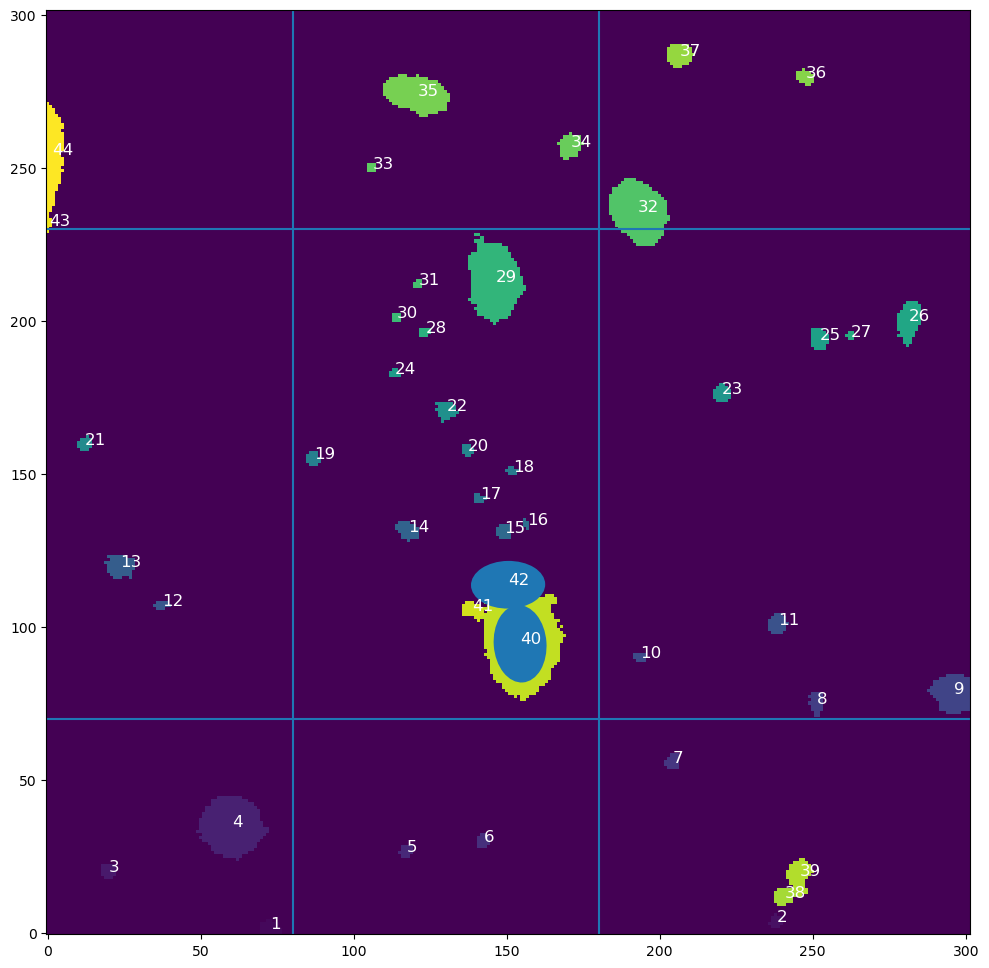

In [9]:
# Labeling the objects
fig, ax = plt.subplots(figsize = (16, 12))
ax.imshow(seg_deblend, origin = 'lower', cmap = 'viridis')
for i in range(len(catalog.label)):
    ax.text(catalog.centroid[i][0], catalog.centroid[i][1], '%s' %(catalog.label[i]), c = 'white', fontsize = '12')
    if catalog.label[i] in [40, 42]:
        ax.scatter(catalog.xcentroid[i], catalog.ycentroid[i], s = 20, c = 'k')

        ellipse = Ellipse((catalog.xcentroid[i], catalog.ycentroid[i]), width = semi_major[i].value\
                          , height = semi_minor[i].value, angle = catalog.orientation.value[i])
        ax.add_patch(ellipse)

plt.savefig("Segm_map.png")
plt.axhline(y = 70, xmin = 0, xmax = 300)
plt.axhline(y = 230, xmin = 0, xmax = 300)
plt.axvline(x = 80, ymin = 0, ymax = 300)
plt.axvline(x = 180, ymin = 0, ymax = 300)
plt.show()

In [10]:
# Calculating flux
obj = []

flux_table = Table(names = ['object'])
flux_table.add_column(Column(name = 'xcentroid'))
flux_table.add_column(Column(name = 'ycentroid'))

for filt in filt_id:
    flux_table.add_column(Column(name = "%s" %(filt), unit = 'nJy'))
    flux_table.add_column(Column(name = "%s_err" %(filt), unit = 'nJy'))
    
    
for i in range(len(catalog.labels)):
    if 80 < catalog.xcentroid[i] < 180 and 70 < catalog.ycentroid[i] < 230:
            obj.append(catalog.labels[i])
    
    flux_table.add_row()
    flux_table['object'][i] = catalog.labels[i]
    flux_table['xcentroid'][i] = catalog.xcentroid[i]
    flux_table['ycentroid'][i] = catalog.ycentroid[i]
    
    aper = EllipticalAperture((catalog.xcentroid[i], catalog.ycentroid[i]), semi_major[i].value,
                          semi_minor[i].value, theta = catalog.orientation[i])
    for j in filt_id:
        phot = aperture_photometry(get_file(j) + source, aper, method = 'subpixel')
        flux_table[j][i] = abs(phot['aperture_sum'][0])
            
flux_table

<Table length=44>
 object     xcentroid          ycentroid      ...       f444w        f444w_err
                                              ...        nJy            nJy   
float64      float64            float64       ...      float64        float64 
------- ------------------ ------------------ ... ------------------ ---------
    1.0  72.73002670522817 1.3845961732912098 ...  8.432421991694719       0.0
    2.0 238.18095173349198 3.6621414649294826 ...  16.34723705901066       0.0
    3.0 19.995699793485052 20.018637871989124 ... 1246.6296373600787       0.0
    4.0  60.19081115047174 34.665694728789376 ... 252.10689321671285       0.0
    5.0 117.23177454482678 26.595405037733055 ...  6.929535902012139       0.0
    6.0 142.47328356553356 29.919356261495476 ...  16.01759232327808       0.0
    7.0 204.26606396424478  55.83722664320222 ... 16.521159752632954       0.0
    8.0 251.33168662384546  75.10938773149795 ... 24.840503172893076       0.0
    9.0  296.1235855325376   78.1868314458052 ...   82.2303630965948       0.0
    ...                ...                ... ...                ...       ...
   35.0 120.89011536783363 273.76350391463495 ... 113.45256075032054       0.0
   36.0  247.5922762010445  279.4397128863151 ... 25.489038694081827       0.0
   37.0 206.57760922869224  286.9062183697213 ...  30.89111083004041       0.0
   38.0  240.6629198000752 11.660254891619953 ... 45.587946240601596       0.0
   39.0 245.56676592247717  18.84837489970559 ...   55.4420701887738       0.0
   40.0   154.339669643319  94.43734664597157 ...  882.3939077672176       0.0
   41.0 138.73766402478395 105.46846746756579 ...  52.56528684515972       0.0
   42.0  150.4190421865287 113.74236843571627 ...  280.3582918659132       0.0
   43.0 0.3447453241420865 231.30248882537677 ... 19.539546469748018       0.0
   44.0 1.2699328187716603 254.37524309199046 ... 229.55045219196938       0.0

In [11]:
# Checking the accuracy of the photometry on the test object
for filt in filt_id:
    print(filt, ':', np.round(flux_table[filt][2]/ np.sum(source) * 100, 3))

f435w : 99.511
f606w : 99.317
f814w : 98.265
f090w : 99.368
f115w : 99.192
f115wn : 99.293
f150w : 99.314
f150wn : 99.245
f200w : 99.158
f200wn : 99.333
f277w : 99.197
f356w : 99.309
f410m : 99.448
f444w : 99.204


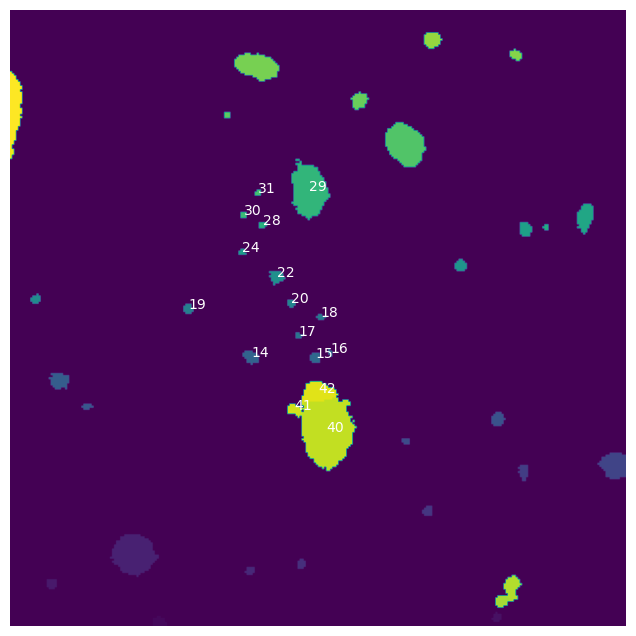

In [12]:
plt.figure(figsize = (12, 8))
plt.imshow(seg_deblend, origin = 'lower')
for i in obj:
    plt.text(catalog.xcentroid[i-1], catalog.ycentroid[i-1], catalog.label[i-1], c = 'white')

plt.axis('off')
plt.savefig("seg_map.png")
plt.show()

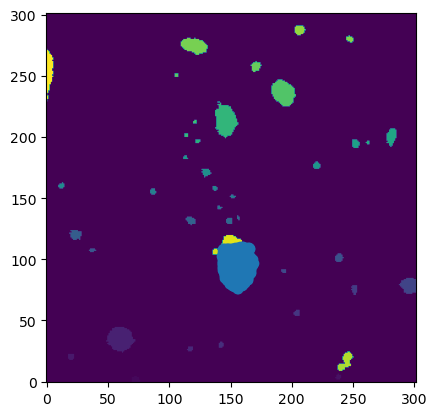

40

In [13]:
plt.imshow(seg_deblend, origin = 'lower')
plt.scatter(np.where(seg_deblend == 40)[1], np.where(seg_deblend == 40)[0])
plt.show()
seg_deblend[100, 150]

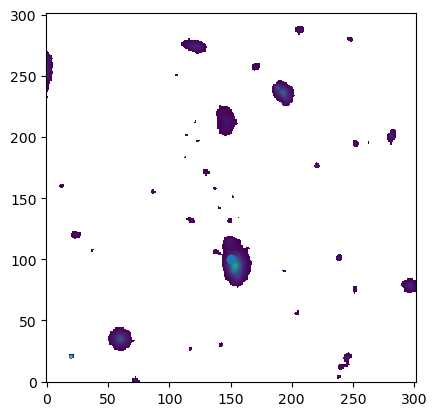

masked

In [14]:
# Creating a mask
combined_mask = np.zeros_like(seg_deblend, dtype=bool)

for label in catalog.labels:
    combined_mask |= seg_deblend == label
    
masked_image_data = np.ma.masked_array(data_bkg, mask=~combined_mask)

plt.imshow(masked_image_data, origin = 'lower')
plt.scatter(150, 100)
plt.show()
masked_image_data[150, 100]

0.0

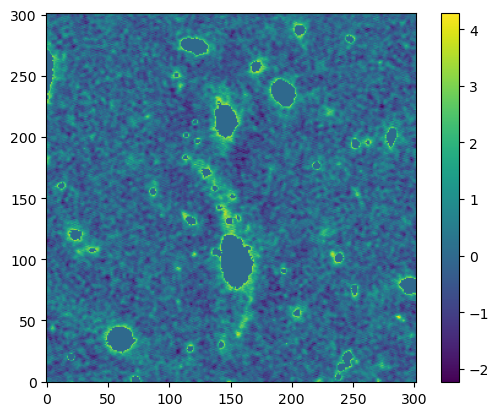

In [15]:
test_ = data_bkg
test_[combined_mask] = 0
plt.imshow(test_, cmap = 'viridis', origin = 'lower')
plt.colorbar()
test_[100, 150]

In [17]:
# Using empty aperture method to calculate the error on the photometry
nsigma, npixels, nlevels, contrast = 2, 5, 32, 0.005
pix_scale = 0.040

box_size = 3.       # in arcsec
box_size = int(box_size/pix_scale)
if box_size%2==0:
    box_size+=1

    
kernel_size = 0.1       # in arcsec
kernel_size = int(kernel_size/pix_scale)
if kernel_size%2==0:
    kernel_size+=1
    

empty_aper_x = {}
empty_aper_y = {}

In [16]:
sigma_clip = SigmaClip(sigma=3., maxiters=50)
bkg_estimator = SExtractorBackground()
bkg_rms_estimator = MADStdBackgroundRMS()

data_ = get_file(filt_id[0])

mask_phot = data_ == 0
bkg = Background2D(data_,box_size,filter_size=kernel_size,edge_method='pad',sigma_clip=sigma_clip,
                                           bkg_estimator=bkg_estimator,bkgrms_estimator=bkg_rms_estimator,
                                           fill_value=0.)#, coverage_mask=masked_image_data.mask)

bkg_globalback = bkg.background_median
bkg_globalrms = bkg.background_rms_median
bkg_image = bkg.background
bkg_rms = bkg.background_rms

bkg_globalback

NameError: name 'box_size' is not defined

In [18]:
N, M = test_.shape
radius = 0.7 / 2./ pix_scale
n_aper = 10 ## Try different numbers to optimize 

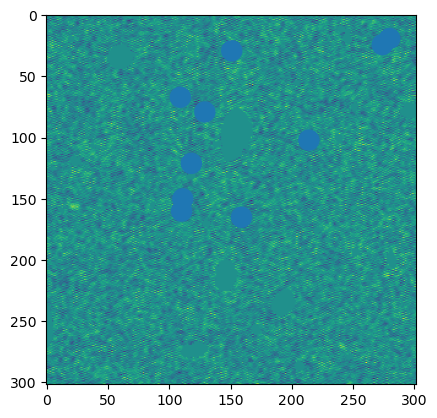

filter F435W done


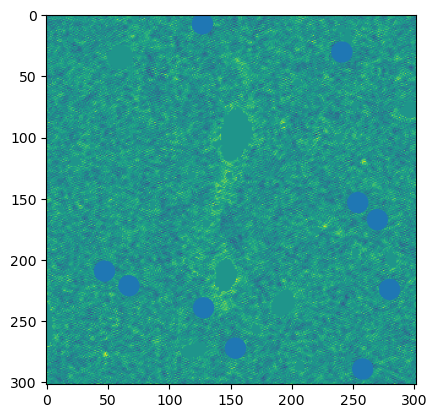

filter F606W done


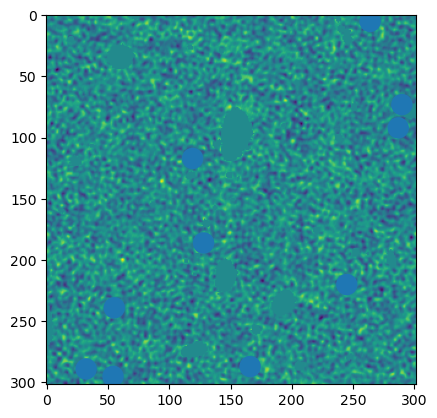

filter F814W done


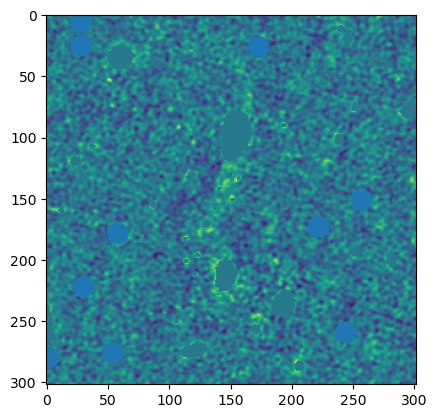

filter F090W done


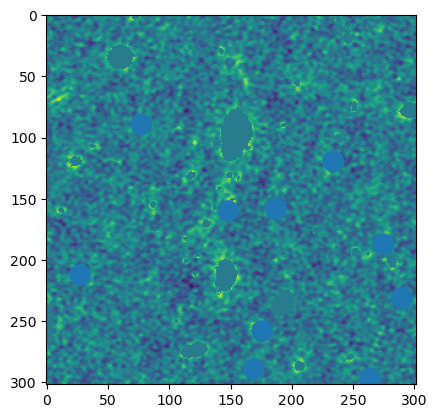

filter F115W done


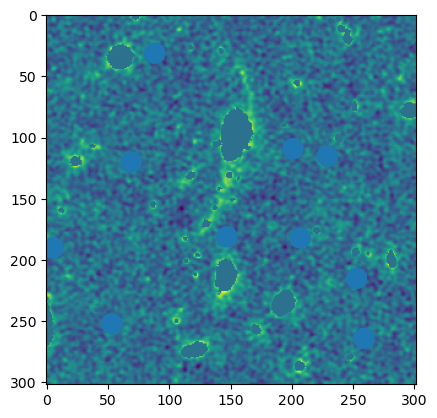

filter F115WN done


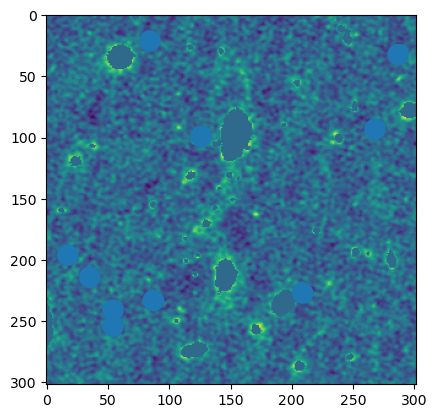

filter F150W done


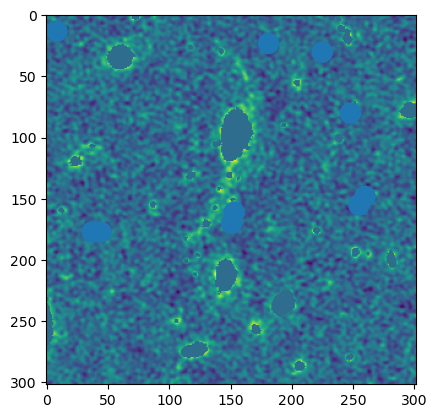

filter F150WN done


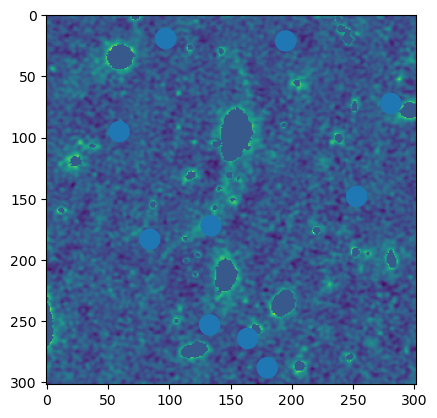

filter F200W done


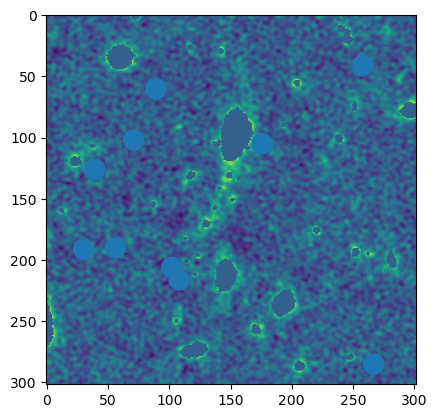

filter F200WN done


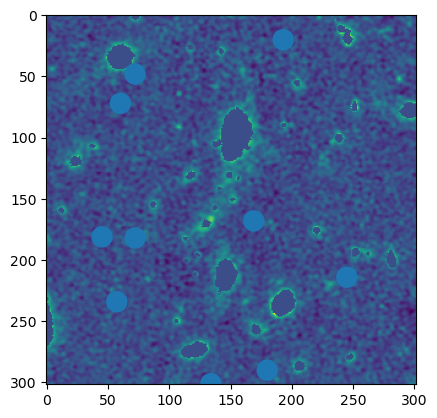

filter F277W done


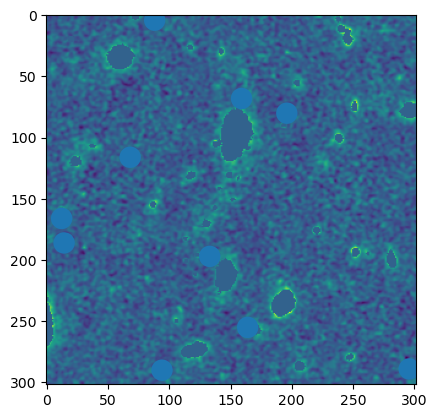

filter F356W done


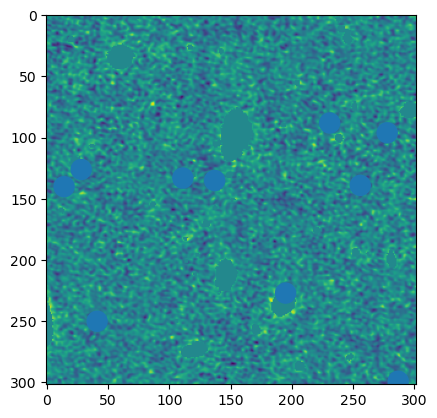

filter F410M done


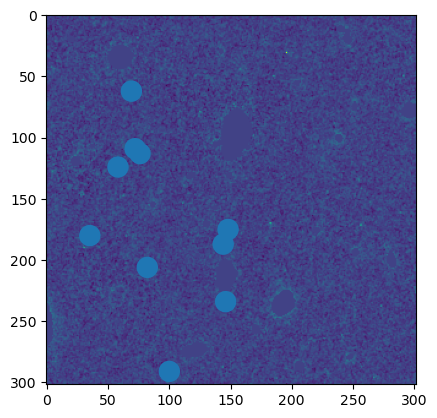

filter F444W done


In [19]:
for filt in filters:
    dat = get_file(filt.lower())
    dat[combined_mask] = 0
    fig, ax = plt.subplots()
    ax.imshow(dat)
    empty_aper_x[filt] = []
    empty_aper_y[filt] = []
    
    
    n_apertures_found = 0
    while n_apertures_found < n_aper:
        position_sum = 1
        while position_sum > 0:
            pos_check = 1
            while pos_check > 0:
                # generate random position
                x = random.randint(0, N-1)
                y = random.randint(0, M-1)
                #
                pos_check = test_[x,y]

            position = np.transpose([y,x])#(x,y)
            aper = CircularAperture(position, r=radius)
            temp_phot_table = aperture_photometry(dat, aper)
            position_sum = temp_phot_table['aperture_sum'][0]
        circle = plt.Circle((x, y), radius)
        ax.add_patch(circle)
        empty_aper_x[filt].append(y)      
        empty_aper_y[filt].append(x)

        n_apertures_found+=1
    
    plt.show()
    print("filter {} done".format(filt))
    

In [20]:
sigma_dict_final = {}
alpha_dict = {}
beta_dict = {}

img_list= []
img_err_list = []

aperture_diameters = np.array([0.3,0.5,0.7,1.0])
diameters_arcsec = np.round(np.arange(aperture_diameters[0],
                                      (aperture_diameters[-1]+0.1),0.1),decimals=1)
radii = diameters_arcsec / 2. / pix_scale  

for filt in filters:
    print("working on filter: {}".format(filt))

    sigma_dict_final[filt] = {}
    sigma_list_filter_all_apers = []

    img = get_file(filt.lower())
    img[combined_mask] = 0
    #plt.imshow(img)
    #plt.colorbar()
    #plt.show()
    mask_phot = img == 0


    for aper_size in range(len(diameters_arcsec)):
        aper_r = radii[aper_size]
        #print(aper_r)
        flux, flux_err, flag = sep.sum_circle(img, empty_aper_x[filt],
                                              empty_aper_y[filt],aper_r,
                                              err=None, gain=None)#, mask=combined_mask)
        len_counts = len(flux)
        flux = flux[~np.isnan(flux) & np.isfinite(flux)]
        #
        y_hist, bins_hist = np.histogram(flux,bins='auto',density=False)
        midbins_hist = midbins(bins_hist)
        # fit a gaussian best fit to the data
        amp_init = np.max(y_hist)
        mu_init = np.mean(flux,dtype='float32')
        sigma_init = np.std(flux,dtype='float64')
        #print([amp_init,mu_init,sigma_init])
        popt, pcov = curve_fit(fit_Gaussian,midbins_hist, y_hist, p0=[amp_init,mu_init,sigma_init],maxfev=int(1e8))

        sigma = np.abs(popt[-1])

        y_gaussian_guess = fit_Gaussian(midbins_hist, amp_init, mu_init, sigma_init)
        y_gaussian_fit = fit_Gaussian(midbins_hist, *popt)

        sigma_list_filter_all_apers.append(sigma)
        if diameters_arcsec[aper_size] in aperture_diameters:
            sigma_dict_final[filt]['APER{:02.0f}'.format(diameters_arcsec[aper_size]*10)] = sigma

working on filter: F435W
working on filter: F606W


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


working on filter: F814W
working on filter: F090W
working on filter: F115W
working on filter: F115WN
working on filter: F150W
working on filter: F150WN
working on filter: F200W
working on filter: F200WN
working on filter: F277W
working on filter: F356W
working on filter: F410M
working on filter: F444W


In [25]:
# Adding errors to the table
sigma_dict_final

for i in range(len(filt_id)):
    flux_table['{}_err'.format(filt_id[i])] = [sigma_dict_final[filters[i]]['APER07'] for filt in filters][i]

flux_table

<Table length=44>
 object     xcentroid      ...       f444w            f444w_err     
                           ...        nJy                nJy        
float64      float64       ...      float64            float64      
------- ------------------ ... ------------------ ------------------
    1.0  72.73002670522817 ...  8.432421991694719 0.4180215948525765
    2.0 238.18095173349198 ...  16.34723705901066 0.4180215948525765
    3.0 19.995699793485052 ... 1246.6296373600787 0.4180215948525765
    4.0  60.19081115047174 ... 252.10689321671285 0.4180215948525765
    5.0 117.23177454482678 ...  6.929535902012139 0.4180215948525765
    6.0 142.47328356553356 ...  16.01759232327808 0.4180215948525765
    7.0 204.26606396424478 ... 16.521159752632954 0.4180215948525765
    8.0 251.33168662384546 ... 24.840503172893076 0.4180215948525765
    9.0  296.1235855325376 ...   82.2303630965948 0.4180215948525765
    ...                ... ...                ...                ...
   35.0 120.89011536783363 ... 113.45256075032054 0.4180215948525765
   36.0  247.5922762010445 ... 25.489038694081827 0.4180215948525765
   37.0 206.57760922869224 ...  30.89111083004041 0.4180215948525765
   38.0  240.6629198000752 ... 45.587946240601596 0.4180215948525765
   39.0 245.56676592247717 ...   55.4420701887738 0.4180215948525765
   40.0   154.339669643319 ...  882.3939077672176 0.4180215948525765
   41.0 138.73766402478395 ...  52.56528684515972 0.4180215948525765
   42.0  150.4190421865287 ...  280.3582918659132 0.4180215948525765
   43.0 0.3447453241420865 ... 19.539546469748018 0.4180215948525765
   44.0 1.2699328187716603 ... 229.55045219196938 0.4180215948525765

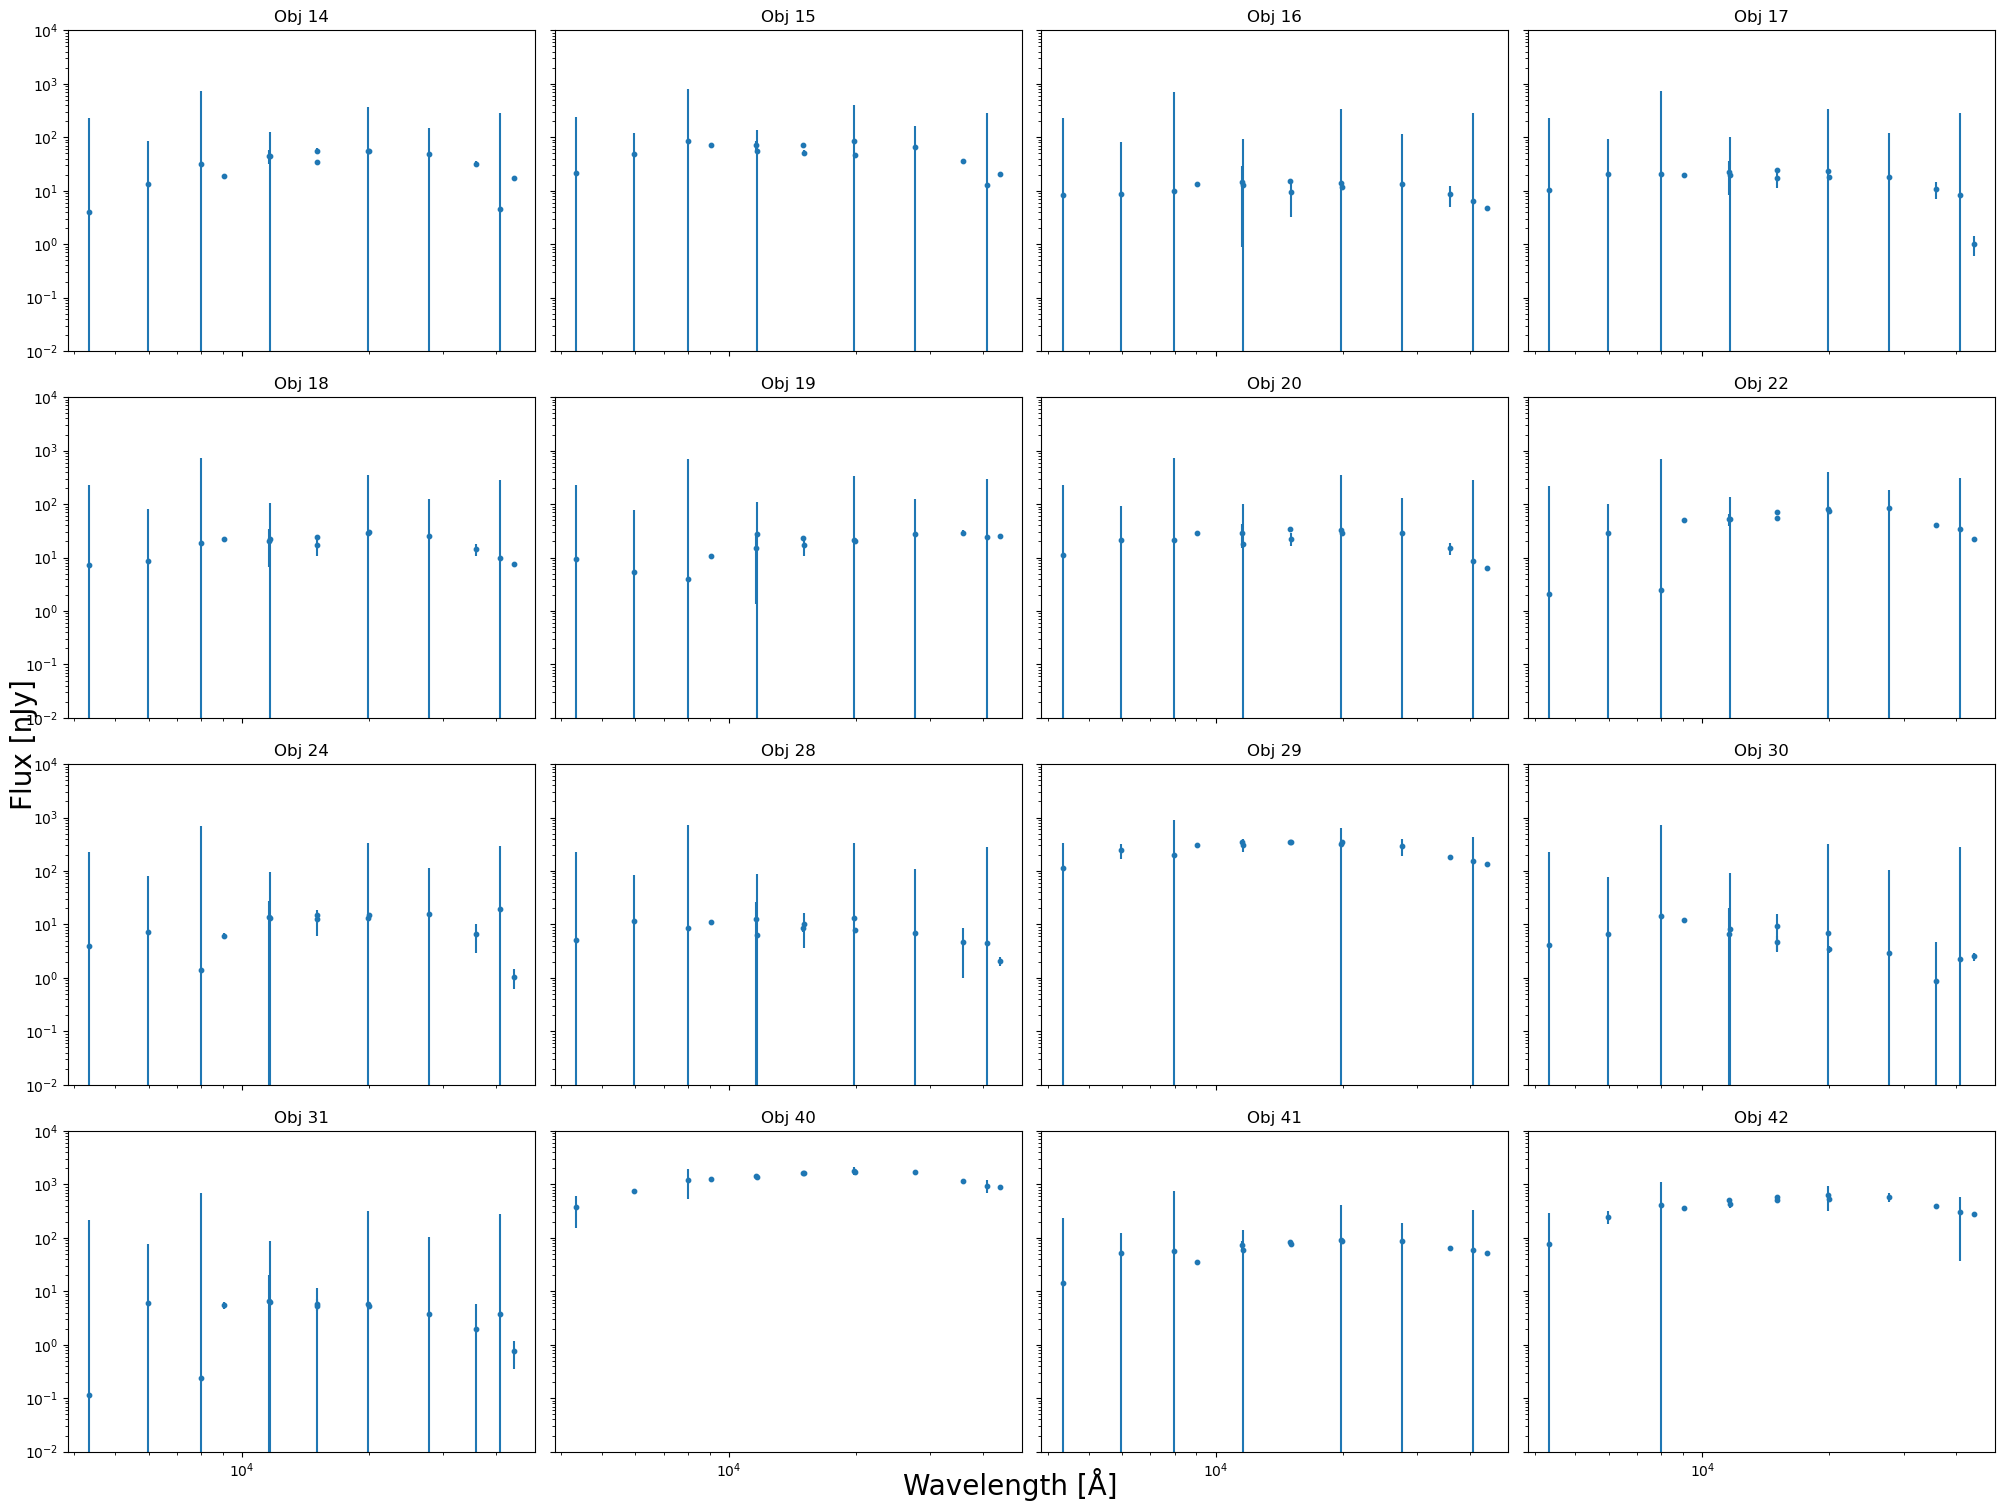

In [26]:
# Plotting fluxes
fig, axes = plt.subplots(4, 4, sharex = True, sharey = True, figsize=(20, 15))
axes = axes.flatten()

for i in range(len(obj)):
    sed = [flux_table[obj[i]-1][j] for j in filt_id]
    err = [sigma_dict_final[filt]['APER07'] for filt in filters]
    ax = axes[i]
    ax.scatter(lam_centers, sed, s = 10)
    ax.errorbar(lam_centers, sed, yerr = err, ls = 'none')
    ax.set_xscale('log'); ax.set_yscale('log')#; plt.ylim(1e-2)
    ax.set_ylim(0.01, 10e3)
    ax.set_title(f"Obj {obj[i]}")
    

fig.text(0.5, 0, 'Wavelength [Å]', ha='center', fontsize = 20)
fig.text(0, 0.5, 'Flux [nJy]', va='center', rotation='vertical', fontsize = 20)
plt.tight_layout()
plt.savefig("Flux_plots.png")
plt.show()

In [23]:
# Saving the table
flux_table.write("Breadcrumbs_phot.fits", format = 'fits', overwrite = True)

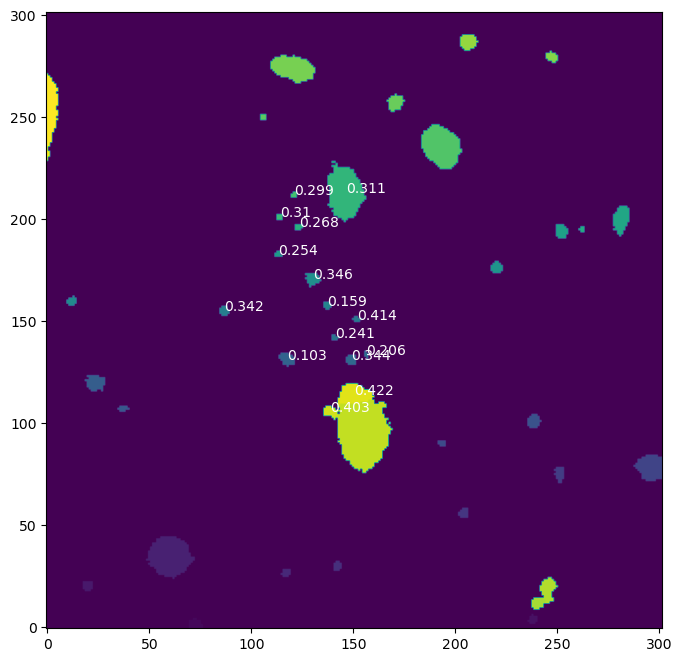

In [24]:
# Adding redshifts to plot
ids = [14, 15, 16, 17, 18, 19, 20, 22, 24, 28, 29, 30, 31, 41, 42]
redshift = [0.10250883275719397,
 0.3435088327571942,
 0.20550883275719406,
 0.2405088327571941,
 0.41350883275719424,
 0.3415088327571942,
 0.15850883275719402,
 0.3455088327571942,
 0.2535088327571941,
 0.2675088327571941,
 0.31050883275719415,
 0.30950883275719415,
 0.29850883275719414,
 0.40250883275719423,
 0.42150883275719425]

plt.figure(figsize = (12,8))
plt.imshow(seg_deblend, origin = 'lower')
for i in range(len(ids)):
    plt.text(catalog.xcentroid[ids[i]-1], catalog.ycentroid[ids[i]-1], round(redshift[i], 3), c = 'white')
    
plt.show()